In [1]:
""" 
This notebook contains the simulations, figures and results 
presented in Chapter 5 of the master's thesis.

In the notebook NN-Classifier-for-hardcoded-policy there is all the code used
initially.

Author: Daniel Salgado Rojo
"""
import tensorflow as tf
import numpy as np
import gym
import gym_pdsystem
from gym import wrappers
import argparse
import pprint as pp

from datetime import datetime

import random
from gym_pdsystem.envs.pdsystem_env import PDSystemEnv

import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct


from matplotlib import animation, rc
import matplotlib.pyplot as plt
from IPython.display import HTML

import os

import pandas as pd
#TO OMMIT WARNINGS
import warnings
warnings.filterwarnings('ignore')

/home/dsalgador/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# The leftmost-empties-tank policy ($\pi_m$)

In [2]:
# Hard-coded policy

def leftmost_emptiest_tank_policy(s, system):
    """
    It is assumed a system with only one Truck (k=1)
    
    Given a PDSystem and its state 's' this (deterministic function) returns
    the tank with minimum load (in case of ties, the leftmost), unless the total load of the truck does not fit
    in that tank (in which case the number of tanks is returned, which stands for staying at the depot).
    Note that if the load of the truck does not fit in the tank with minimum load, it will fit even less
    in the others.
    """
    min_boolean_indexes = np.isin(s, np.min(s))
    min_indexes = np.where(min_boolean_indexes)
    min_indexes = min_indexes[0]

    possible_indexes = []
    
    for tank_visited in min_indexes:
        hypothetical_next_tank_state = s[tank_visited] + system.truck_max_loads
        if hypothetical_next_tank_state <= system.tank_max_loads[tank_visited]:
                    possible_indexes.append(tank_visited)
    
    
    if len(possible_indexes) != 0:
        tank_to_go = possible_indexes[0] # THIS IS WHAT CHANGES WITH RESPECT TO THE emptiest_tank_policy()
        return tank_to_go
    else:
        return system.n #stay in the depot

# Creating train, validation and test sets

In [3]:
################################################################################
# Example k = 1 (trucks), n = 3 (tanks)
################################################################################

# Variables to initialize a gym-pdsystem environment
# ENSURE THAT THE FOLLOWING VARIABLES COINCIDES WITH THE CASE k=1 n=3 in the constants.py file
# AND ALSO THAT CASE = -1 (or other negative number)

TANK_MAX_LOADS = np.array([100., 200, 100.])
LEVEL_PERCENTAGES = np.array([ #b , c, e
                                                [0.02, 0.31, 0.9],
                                                [0.01, 0.03, 0.9],
                                                [0.05, 0.16, 0.9]
                                                   ])
TRUCK_MAX_LOADS = np.array([50.])
GRAPH_WEIGHTS = np.array([32., 159., 162., 0.]) #useless in the current notbook

DISCRETE = True
################################################################################

boolean = (not np.array_equal(TANK_MAX_LOADS, ct.TANK_MAX_LOADS) ) or  (not np.array_equal(LEVEL_PERCENTAGES,ct.LEVEL_PERCENTAGES)) 
boolean = boolean or ( not np.array_equal(TRUCK_MAX_LOADS, ct.TRUCK_MAX_LOADS))
boolean = boolean or  (not np.array_equal(GRAPH_WEIGHTS, ct.GRAPH_WEIGHTS))
boolean = boolean or not (DISCRETE == ct.DISCRETE)
if boolean:
    raise Exception("ENSURE THAT THE VARIABLES ABOVE COINCIDE WITH THE CASE k=1 n=3 in the constants.py file")

In [4]:
# Environment initialization and random seeds for reproducibility
episode_length = 30
seed = 42

system = PDSystemEnv(tank_max_loads = TANK_MAX_LOADS, level_percentages = LEVEL_PERCENTAGES,
                     truck_max_loads = TRUCK_MAX_LOADS, graph_weights = GRAPH_WEIGHTS,  
                     discrete = DISCRETE)

env = gym.make("PDSystemEnv-v0")
env._max_episode_steps = episode_length

np.random.seed(seed)
tf.set_random_seed(seed)
env.seed(seed)


# Sizes for the train, validation and test data. And filenames to save them.
N_TRAIN = 10**4; SEED_TRAIN = 42; train_file = 'train.txt'
N_VAL = 10**3; SEED_VAL = 50; validation_file = 'validation.txt'
N_TEST = 10**3; SEED_TEST = 58; test_file = 'test.txt'

# Number of decimals to round the outputted data
round_decimals = 5

# Set to True only when wanting to create the datasets.
CREATE_DATASETS = True

def create_datasets(outputfile, n_observations, seed = None, round_decimals = round_decimals): 
    """
    Creates train, validation and test sets for multiclass classification, initializing
    each of the tanks of the gym-pdsystem uniformly. Each observation consists in the initial levels 
    of each tank (x) and the action that the truck should do according to the leftmost-emptiest-tank policy
    (the target y).
    """
    if seed != None:
        np.random.seed(seed)
        
    with open('{}'.format(outputfile),'w') as f:
        np.savetxt(f, [np.array(['tank1', 'tank2', 'tank3', 'target'])], fmt = "%s", delimiter=',')
        print(f"Creating {outputfile} file...")
        for i in range(n_observations):
            if i % (int(n_observations / 100)) == 0:
                p = round(i/n_observations *100,1)
                print("\rPercentage: {} %".format(p), end="")
            obs = []
            for max_load in TANK_MAX_LOADS:
                random_load = np.random.random() * max_load
                obs.append(np.round(random_load,round_decimals)  )

            obs.append(leftmost_emptiest_tank_policy(np.array(obs), system))   
            np.savetxt(f, [np.array(obs)], fmt = ('%f','%f', '%f', '%d'), delimiter=',')  #!! fmt only for n=3
    print(f"\rCreated {outputfile} file.")
    
if CREATE_DATASETS:          
    create_datasets(train_file, N_TRAIN, SEED_TRAIN) 
    create_datasets(validation_file, N_VAL, SEED_VAL)      
    create_datasets(test_file, N_TEST, SEED_TEST)            

Creating train.txt file...
Created train.txt file.
Creating validation.txt file...
Created validation.txt file.
Creating test.txt file...
Created test.txt file.


In [5]:
train = pd.read_table(train_file, sep = ",")
test = pd.read_table(test_file, sep = ",")
validation = pd.read_table(validation_file, sep = ",")

# Exploring the train dataset

As expected the load of the tanks is initialized with a uniform distribution between 0 and the maximum
load capacity of each tank.

Note that the dataset is not balanced in terms of the target values, since we have about two times of observations
for when the targets are tank 0 and tank 2, compared to tank 1 and ``staying at the depot'' (y=3).

The fact that tank 1 appears as target about half the times it does with tanks 0 and 2 is intuitively explained by the fact that tank 1 has de double of maximum capacity than the other two so the probability of being the tank with minium load is half the probability that the other two tanks were the ones with the minimum.

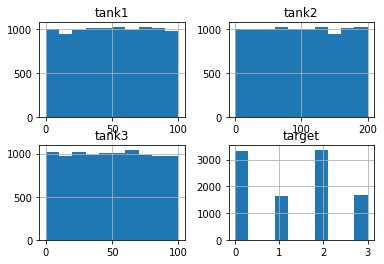

In [6]:
train.hist()
plt.show()

## Prepare data for feeding it to different classifiers

In [7]:
y_train = train["target"].values#.reshape((N_TRAIN, ))
X_train = train[["tank1", "tank2","tank3"]].values

y_test = test["target"].values#.reshape((N_TEST, ))
X_test = test[["tank1", "tank2","tank3"]].values

y_val = validation["target"]#.reshape((N_VAL, ))
X_val = validation[["tank1", "tank2","tank3"]].values

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

# Stochastic Gradient Descent classifier

In [8]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix

In [9]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train);

# Random forest classifier

# Neural Network Classifier

In [10]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## Deep Neural Network model

In [11]:
reset_graph()

seed = 42
learning_rate = 0.01 #0.01

model_file = './final_nn_classifier_{}.ckpt'.format(learning_rate)
graph_file =  '{}.meta'.format(model_file)
epochs = 2000 #2000
batch_size = 50 #50

summary_freq = 100#np.ceil(epochs/10) #200


hidden1_neurons = 20 #100
hidden2_neurons = 10 #50

scaling = False

if scaling:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.astype(np.float64))
    X_val = scaler.fit_transform(X_val.astype(np.float64))
    X_test = scaler.fit_transform(X_test.astype(np.float64))
    model_file = './final_nn_classifier_scaled_{}.ckpt'.format(learning_rate)

with tf.name_scope("dnn"):
            tf.set_random_seed(seed)
            # 1. Parameters to determine the NN architecture

            n_inputs = env.observation_space.shape[1]
            n_hidden1 = hidden1_neurons; activation1 = tf.nn.elu
            n_hidden2 = hidden2_neurons; activation2 = tf.nn.elu
            n_outputs = env.action_space.shape[1]

            initializer = tf.contrib.layers.variance_scaling_initializer()

            # 2. Build the Neural Network
            
            X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
            y = tf.placeholder(tf.int64, shape = (None), name = "y")
            
            hidden1 = tf.layers.dense(X, n_hidden1, activation = activation1,
                                     kernel_initializer = initializer)
            hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = activation2,
                                     kernel_initializer = initializer)
            logits = tf.layers.dense(hidden2, n_outputs,kernel_initializer = initializer)
            
with tf.name_scope("loss"):
            
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,
                                                                      logits = logits)
            loss = tf.reduce_mean(xentropy, name = "loss")
            
tf.summary.scalar('average_cross_entropy', loss)
            
with tf.name_scope("train"):
            # Optimization Op
            optimizer = tf.train.AdamOptimizer(learning_rate)
            optimize = optimizer.minimize(loss)
            
with tf.name_scope("eval"):
            correct = tf.nn.in_top_k(logits, y, 1)
            accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
tf.summary.scalar('accuracy', accuracy)

            
with tf.name_scope("action"):
            outputs = tf.nn.softmax(logits)
            # 3. Select a random action (where to go) based on the estimated probabilities
            action = tf.multinomial(tf.log(outputs), num_samples = 1)

merged = tf.summary.merge_all()
init = tf.global_variables_initializer()
        
if model_file != None:
            saver = tf.train.Saver()
        

def fetch_batch(X,y,epoch, batch_index, batch_size, data_size, n_batches):
        #np.random.seed(epoch * n_batches + batch_index)  
        indices = np.random.randint(data_size, size=batch_size)  
        X_batch = X[indices] 
        y_batch = y[indices] 
        return X_batch, y_batch
    
    
best_acc_val = 0
acc_val = 0

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
log_dir = "{}/run-{}/".format(root_logdir, now)


Instructions for updating:
Use the retry module or similar alternatives.


## Training

In [12]:
with tf.Session() as sess:
        train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
        val_writer = tf.summary.FileWriter(log_dir + '/val')
        
        init.run()
        N_TRAIN = X_train.shape[0]
        m = y_train.shape[0]
        
        n_batches = int(np.ceil(N_TRAIN/ batch_size))
        #print(n_batches)
             
        for epoch in range(epochs+1):
            print("\rEpoch: {}".format(epoch), end="")            
            for batch_index in range(n_batches):
                X_batch, y_batch = fetch_batch(X_train,y_train,epoch, batch_index, batch_size, m, n_batches)
                #print("Xbatch shape",X_batch.shape, "y_batch shape", y_batch.shape)
                sess.run(optimize, feed_dict={
                                    y: y_batch,
                                    X: X_batch
                                })
    
            if summary_freq != None: 
                            
                if epoch % summary_freq  == 0:
                    

                    summary, acc_train = sess.run([merged, accuracy], feed_dict={
                                        y: y_batch,
                                        X: X_batch
                                    })
                    train_writer.add_summary(summary, epoch)

                    summary, acc_val = sess.run([merged, accuracy], feed_dict={
                                        y: y_val,
                                        X: X_val
                                    }) 
                                    
                    val_writer.add_summary(summary, epoch)

                    best_acc_val = max(best_acc_val, acc_val)

                    print(". Train (batch) accuracy: ", acc_train, 
                          " Validation accuracy: ", acc_val)
                    if best_acc_val <= acc_val:                        
                        save_path = saver.save(sess, model_file)
                        print("Saved model with validation accuracy ", acc_val)
        train_writer.close()
        val_writer.close()                            
        #save_path = saver.save(sess, model_file)   

Epoch: 0. Train (batch) accuracy:  0.42  Validation accuracy:  0.618
Saved model with validation accuracy  0.618
Epoch: 100. Train (batch) accuracy:  1.0  Validation accuracy:  0.959
Saved model with validation accuracy  0.959
Epoch: 200. Train (batch) accuracy:  1.0  Validation accuracy:  0.979
Saved model with validation accuracy  0.979
Epoch: 300. Train (batch) accuracy:  1.0  Validation accuracy:  0.996
Saved model with validation accuracy  0.996
Epoch: 400. Train (batch) accuracy:  1.0  Validation accuracy:  0.984
Epoch: 500. Train (batch) accuracy:  0.96  Validation accuracy:  0.988
Epoch: 600. Train (batch) accuracy:  1.0  Validation accuracy:  0.993
Epoch: 700. Train (batch) accuracy:  1.0  Validation accuracy:  0.972
Epoch: 800. Train (batch) accuracy:  0.98  Validation accuracy:  0.989
Epoch: 900. Train (batch) accuracy:  1.0  Validation accuracy:  0.995
Epoch: 1000. Train (batch) accuracy:  1.0  Validation accuracy:  0.994
Epoch: 1100. Train (batch) accuracy:  1.0  Validatio

## Testing

In [13]:
with tf.Session() as sess: 
    saver.restore(sess, model_file)
    acc_test = sess.run(accuracy, feed_dict={
                                    y: y_test,
                                    X: X_test
                               })
    print(" Test accuracy of the best model saved (according to validation accuracy): ", acc_test)

INFO:tensorflow:Restoring parameters from ./final_nn_classifier_0.01.ckpt
 Test accuracy of the best model saved (according to validation accuracy):  0.985


## "Playing" the product delivery game with the learnt policy

In [14]:
episode_length = 30
seed = 80

system = PDSystemEnv(tank_max_loads = TANK_MAX_LOADS, level_percentages = LEVEL_PERCENTAGES,
                     truck_max_loads = TRUCK_MAX_LOADS, graph_weights = GRAPH_WEIGHTS,  
                     discrete = DISCRETE)
# ENSURE TO SET CASE = -1 (or another negative number) in the
# constants.py file

env = gym.make("PDSystemEnv-v0")
env._max_episode_steps = episode_length

In [15]:
frames = []
n_episodes = 10

with tf.Session() as sess:
        sess.run(init)
        saver.restore(sess, model_file)
        for episode in range(n_episodes):
            state = env.reset()
            for step in range(episode_length):
                system.state = state
                img = system.visualize()
                frames.append(img)

                action_val = action.eval(feed_dict={X: state.reshape(1, n_inputs)})
 
                state, reward, done, info = env.step(action_val[0])
                #print(action_val[0],emptiest_tank_policy(state, system))
        
                if done:
                    break
        env.close()

INFO:tensorflow:Restoring parameters from ./final_nn_classifier_0.01.ckpt


### Visualizing the performance of the policy


In [16]:
test_anim = ut.create_system_animation(frames, n_episodes * episode_length)
plt.close()

HTML(test_anim.to_html5_video())